In [1]:
import tensorflow as tf
import numpy as np
import os
import utils as ut
import models as models
import Spectograms as spectograms
import SoundUtils as SU
import scipy.misc
from PIL import Image

%load_ext autoreload
%autoreload 2

In [7]:
content_sound = "sound/content_fcjf0_SA1.WAV"
style_sound = "sound/style_mcpm0_SA1.WAV"

model_weights_path = '/Users/Sergey/Thesis/Projects/neural-art-tf/models/vgg'

# content_weights_path = "/Volumes/Storage/Datasets/TIMIT/Phonemes/fc7/p_weights.npy"
# content_bias_path = "/Volumes/Storage/Datasets/TIMIT/Phonemes/fc7/p_bias.npy"

# style_weights_path = "/Volumes/Storage/Datasets/TIMIT/Speakers/fc7/s_weights.npy"
# style_bias_path = "/Volumes/Storage/Datasets/TIMIT/Speakers/fc7/s_bias.npy"
content_weights_path = "Weights/p_weights.npy"
content_bias_path = "Weights/p_bias.npy"

style_weights_path = "Weights/s_weights.npy"
style_bias_path = "Weights/s_bias.npy"


array_inversion_file = "/Users/Sergey/Thesis/SpectrogramInversion1.02b/invertMe.mat"
array_inversion_shown_file = "/Users/Sergey/Thesis/SpectrogramInversion1.02b/invertMeShown.mat"

full_spect_image = "full_spect.png"
temp_folder = "Temp"
images_folder = "Images"
style_images_folder = "StyleImages"
transformed_images_folder = "TransformedImages"

device="/cpu:0"

windowSize = 256
frameStep = 64

num_iters = 5000

In [9]:
wav_file = SU.PCM2Wav(style_sound, temp_folder)
imageRGB, minEl, maxEl = spectograms.SpectogramToImage(wav_file, full_spect_image)
imgS = Image.fromarray(imageRGB)


wav_file = SU.PCM2Wav(content_sound, temp_folder)
imageRGB, minEl, maxEl = spectograms.SpectogramToImage(wav_file, full_spect_image)
imgC = Image.fromarray(imageRGB)


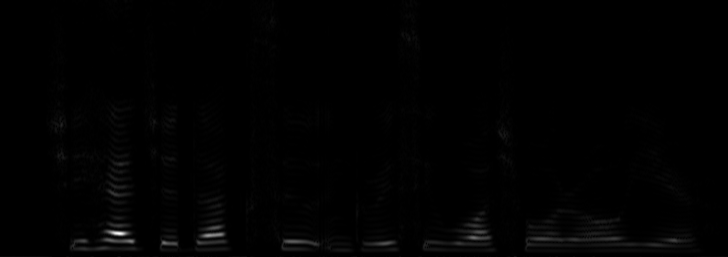

In [10]:
#content 
imgC

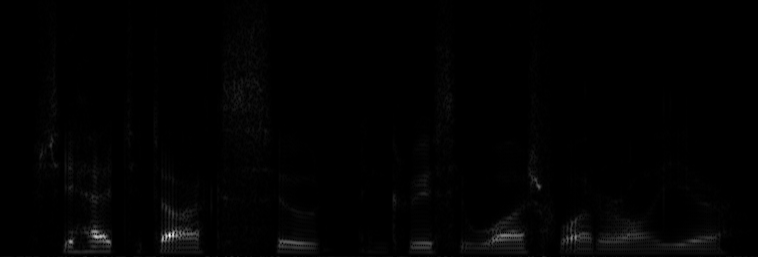

In [11]:
#style
imgS

In [13]:
def SeparateIntoChunksAndSave(sound, folder):
    #creating sequence of images
    wav_file = SU.PCM2Wav(sound, temp_folder)
    imageRGB, minEl, maxEl = spectograms.SpectogramToImage(wav_file, full_spect_image)

    chunkLength = 11
    totalFeatures = imageRGB.shape[1]
    #The stepLength is 1 therefore the number of chunks is calculated as follows
    numChunks = totalFeatures-chunkLength + 1

    for i in range(numChunks):
        chunk = imageRGB[:,i:i+chunkLength,:]
        chunk = scipy.misc.imresize(chunk, (224, 224))
        pa = folder + "/" + str(i) + ".png"
        spectograms.SaveRGB(chunk, pa)

In [14]:
SeparateIntoChunksAndSave(style_sound, style_images_folder)
SeparateIntoChunksAndSave(content_sound, images_folder)

In [19]:
params = np.load(model_weights_path).item()
content_weights = np.load(content_weights_path)
content_bias = np.load(content_bias_path)
style_weights = np.load(style_weights_path)
style_bias = np.load(style_bias_path)

In [ ]:
#determine wanted style
g = tf.Graph()
styles = []
with g.device(device), g.as_default(), tf.Session(graph=g, config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    for i in range(100, 300):
        img_path = style_images_folder + "/" + str(i) + ".png"
        img = spectograms.ReadRGB(img_path)
        style_image = ut.process_image(img)
        #style
        sW = tf.constant(style_weights)
        sB = tf.constant(style_bias)

        image = tf.constant(style_image)
        model = models.getModel(image, params)
        fc7_image_val = sess.run(model.y())

        style_values= tf.nn.softmax(tf.matmul(fc7_image_val,sW) + sB)
        st =  style_values.eval()

        styles.append(st)
        print st
    

[[  3.25229135e-04   3.26954620e-07   1.02821905e-02   3.95668894e-06
    9.01874737e-05   9.42405904e-07   1.09330911e-04   3.34044562e-05
    2.02132342e-03   9.87133145e-01]]


In [5]:
chunk_number = 78
test_image = images_folder + "/" + "78.png"
img = spectograms.ReadRGB(test_image)
#dispImg = Image.fromarray(img)
test_image

'Images/78.png'

In [ ]:
### Trasforming

In [5]:
content_image = ut.process_image(img)
sess = tf.InteractiveSession()
print "Load content values and calculate style and content softmaxes"
#content
cW = tf.constant(content_weights)
cB = tf.constant(content_bias)
#style
sW = tf.constant(style_weights)
sB = tf.constant(style_bias)

image = tf.constant(content_image)
model = models.getModel(image, params)
fc7_image_val = sess.run(model.y())

#content_values= tf.nn.softmax(tf.matmul(fc7_image_val,cW) + cB)
#style_values= tf.nn.softmax(tf.matmul(fc7_image_val,sW) + sB)

print "Generate noise"
gen_image = tf.Variable(tf.truncated_normal(content_image.shape, stddev=20), trainable=True, name='gen_image')
model = models.getModel(gen_image, params)
fc7_gen_image_val = model.y()

#content_transformed_values= tf.nn.softmax(tf.matmul(fc7_gen_image_val,cW) + cB)
#style_transformed_values= tf.nn.softmax(tf.matmul(fc7_gen_image_val,sW) + sB)


L_Content = 0.0
L_Style = 0.0
L_Content += tf.nn.l2_loss(fc7_gen_image_val - fc7_image_val)

#L_Content += tf.nn.l2_loss(content_transformed_values - content_values)
#L_Style += tf.nn.l2_loss(style_transformed_values - style_values)

# The loss
L=L_Content #+ L_Style



Load content values and calculate style and content softmaxes
Generate noise


In [6]:
# The optimizer
global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(learning_rate=0.5, global_step=global_step, 
                                           decay_steps=100, decay_rate=0.94, staircase=True)
train_step = tf.train.AdamOptimizer(learning_rate).minimize(L, global_step=global_step)

tf.scalar_summary("L_content", L_Content)

In [7]:
print "Start calculation..."
# The optimizer has variables that require initialization as well
sess.run(tf.initialize_all_variables())
for i in range(num_iters):
    if i % 10 == 0:
        gen_image_val = sess.run(gen_image)
        
        #saving image
        img = gen_image_val.copy()
        img = ut.add_mean(img)
        img = np.clip(img[0, ...],0,255).astype(np.uint8)
        p = transformed_images_folder + "/" + str(chunk_number) + "_" +  str(i) + ".png"
        #save_image(gen_image_val, i, transformed_images_folder)
        spectograms.SaveRGB(img, p)
        print "L_content", sess.run(L_Content)
        #print "L_style", sess.run(L_Style)
        print "L", sess.run(L)
        # Increment summary
        #sess.run(tf.assign(gen_image_addmean, add_mean(gen_image_val)))
        #summary_str = sess.run(summary_op)
        #summary_writer.add_summary(summary_str, i)
    print "Iter:", i
    sess.run(train_step)

Start calculation...
L_content 1516.42
L 1516.42
Iter: 0
Iter: 1
Iter: 2
Iter: 3
Iter: 4
Iter: 5
Iter: 6
Iter: 7
Iter: 8
Iter: 9
L_content 503.141
L 503.141
Iter: 10
Iter: 11
Iter: 12
Iter: 13
Iter: 14
Iter: 15
Iter: 16
Iter: 17
Iter: 18
Iter: 19
L_content 285.7
L 285.7
Iter: 20
Iter: 21
Iter: 22
Iter: 23
Iter: 24
Iter: 25
Iter: 26
Iter: 27
Iter: 28
Iter: 29
L_content 182.684
L 182.684
Iter: 30
Iter: 31
Iter: 32
Iter: 33
Iter: 34
Iter: 35
Iter: 36
Iter: 37
Iter: 38
Iter: 39
L_content 125.705
L 125.705
Iter: 40
Iter: 41
Iter: 42
Iter: 43
Iter: 44
Iter: 45
Iter: 46
Iter: 47
Iter: 48
Iter: 49
L_content 89.81
L 89.81
Iter: 50
Iter: 51
Iter: 52
Iter: 53
Iter: 54
Iter: 55
Iter: 56
Iter: 57
Iter: 58
Iter: 59
L_content 69.2157
L 69.2157
Iter: 60
Iter: 61
Iter: 62
Iter: 63
Iter: 64
Iter: 65
Iter: 66
Iter: 67
Iter: 68
Iter: 69
L_content 55.6348
L 55.6348
Iter: 70
Iter: 71
Iter: 72
Iter: 73
Iter: 74
Iter: 75
Iter: 76
Iter: 77
Iter: 78
Iter: 79
L_content 46.1366
L 46.1366
Iter: 80
Iter: 81
Iter: 8

KeyboardInterrupt: 

In [37]:
sess.close()

In [9]:
g = tf.Graph()
content_image = ut.process_image(img)
with g.device(device), g.as_default(), tf.Session(graph=g, config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    
    print "Load content values and calculate style and content softmaxes"
    #content
    cW = tf.constant(content_weights)
    cB = tf.constant(content_bias)
    #style
    sW = tf.constant(style_weights)
    sB = tf.constant(style_bias)

    image = tf.constant(content_image)
    model = models.getModel(image, params)
    fc7_image_val = sess.run(model.y())

    content_values= tf.nn.softmax(tf.matmul(fc7_image_val,cW) + cB)
    style_values= tf.nn.softmax(tf.matmul(fc7_image_val,sW) + sB)
    
    print "Generate noise"
    gen_image = tf.Variable(tf.truncated_normal(content_image.shape, stddev=20), trainable=True, name='gen_image')
    model = models.getModel(gen_image, params)
    fc7_gen_image_val = model.y()

    content_transformed_values= tf.nn.softmax(tf.matmul(fc7_gen_image_val,cW) + cB)
    style_transformed_values= tf.nn.softmax(tf.matmul(fc7_gen_image_val,sW) + sB)
    

    L_Content = 0.0
    L_Style = 0.0
    L_Content += tf.nn.l2_loss(content_transformed_values - content_values)
    L_Style += tf.nn.l2_loss(style_transformed_values - style_values)

    # The loss
    L=L_Content + L_Style
    
    # The optimizer
    global_step = tf.Variable(0, trainable=False)
    learning_rate = tf.train.exponential_decay(learning_rate=2.0, global_step=global_step, 
                                               decay_steps=100, decay_rate=0.94, staircase=True)
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(L, global_step=global_step)

    tf.scalar_summary("L_content", L_Content)

    print "Start calculation..."
    # The optimizer has variables that require initialization as well
    sess.run(tf.initialize_all_variables())
    for i in range(num_iters):
        if i % 10 == 0:
            gen_image_val = sess.run(gen_image)

            #saving image
            img = gen_image_val.copy()
            img = ut.add_mean(img)
            img = np.clip(img[0, ...],0,255).astype(np.uint8)
            p = transformed_images_folder + "/" + str(chunk_number) + "_" +  str(i) + ".png"
            #save_image(gen_image_val, i, transformed_images_folder)
            spectograms.SaveRGB(img, p)
            print "L_content", sess.run(L_Content)
            print "L_style", sess.run(L_Style)
            print "L", sess.run(L)
            # Increment summary
            #sess.run(tf.assign(gen_image_addmean, add_mean(gen_image_val)))
            #summary_str = sess.run(summary_op)
            #summary_writer.add_summary(summary_str, i)
        print "Iter:", i
        sess.run(train_step)
    

Load content values and calculate style and content softmaxes
Generate noise


ValueError: Incompatible shapes for broadcasting: TensorShape([Dimension(1), Dimension(60)]) and TensorShape([Dimension(1), Dimension(10)])

In [ ]:
output_image_path = 'neural-art-tf/output/neural_art_2016_02_22_09_23_46_iteration160.png'
output_image = read_image(output_image_path, width)
final_img = add_mean(output_image)
save_image(final_img, 200, out_dir)